In [2]:
# !sudo apt install swig

In [3]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

# Initializing

In [4]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from utils import PortfolioOptimizationEnv, custom_reward_function, sharpe_ratio_reward_function
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Data Import and Preprocessing

In [5]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "GOOG", "XOM"
]
START_DATE = '2011-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

##COVARIATE 1: PRICES

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (32700, 8)


In [6]:
##COVARIATES 2,3: VIX, FEAR/GREED INDEX

combined_spy_vix_fear_greed = pd.read_csv('datasets/VIX_feargreed/spy_vix_fear_greed_2011_2023.csv')


portfolio_raw_df['date'] = pd.to_datetime(portfolio_raw_df['date'])
combined_spy_vix_fear_greed['Date'] = pd.to_datetime(combined_spy_vix_fear_greed['Date'])


df_portfolio_comb = pd.merge(portfolio_raw_df, combined_spy_vix_fear_greed, left_on='date', right_on='Date', how='left')


df_portfolio_comb = df_portfolio_comb.drop(columns=['Date'])
df_portfolio_comb['date'] = df_portfolio_comb['date'].dt.strftime('%Y-%m-%d')

In [7]:
##COVARIATE 4: STOCK HISTORICAL RATINGS

FMP_historical_ratings = pd.read_csv('datasets/historical_ratings/FMP_historical_ratings.csv')

df_portfolio_comb_2 = df_portfolio_comb.merge(
    FMP_historical_ratings[['date', 'symbol', 'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore']],
    left_on=['date', 'tic'],
    right_on=['date', 'symbol'],
    how='left' )

df_portfolio_comb_2.drop(columns=['symbol'], inplace=True)

In [8]:
##COVARIATE 5: Macro Indicators

expenses = pd.read_csv('datasets/macro_indicators/expenses.csv')
gdp = pd.read_csv('datasets/macro_indicators/gdp.csv')
goods_services = pd.read_csv('datasets/macro_indicators/goods_and_services.csv')
pound_dollar = pd.read_csv('datasets/macro_indicators/pound-dollar-exchange-rate-historical-chart.csv')
unemployment = pd.read_csv('datasets/macro_indicators/unemployment.csv')
index_consumer_services = pd.read_csv('datasets/macro_indicators/index_consumer_services.csv')

df_portfolio_comb_2['date'] = pd.to_datetime(df_portfolio_comb_2['date'])
expenses['date'] = pd.to_datetime(unemployment['date'])
gdp['date'] = pd.to_datetime(gdp['DATE'])
goods_services['date'] = pd.to_datetime(goods_services['date'])
pound_dollar['date'] = pd.to_datetime(pound_dollar['date'])
unemployment['date'] = pd.to_datetime(unemployment['date'])
index_consumer_services['date'] = pd.to_datetime(index_consumer_services['date'])

df_portfolio_comb_3 = pd.merge(df_portfolio_comb_2, expenses, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, gdp, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, goods_services, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, pound_dollar, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, unemployment, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, index_consumer_services, on='date', how='left')

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_3 = df_portfolio_comb_3.sort_values(by=['date', 'tic'])

# Forward fill missing data
df_portfolio_comb_3['expenses'] = df_portfolio_comb_3['expenses'].ffill()
df_portfolio_comb_3['GDP'] = df_portfolio_comb_3['GDP'].ffill()
df_portfolio_comb_3['exports'] = df_portfolio_comb_3['exports'].ffill()
df_portfolio_comb_3['imports'] = df_portfolio_comb_3['imports'].ffill()
df_portfolio_comb_3['pound_dollar_exchange_rate'] = df_portfolio_comb_3['pound_dollar_exchange_rate'].ffill()
df_portfolio_comb_3['unemployment'] = df_portfolio_comb_3['unemployment'].ffill()
df_portfolio_comb_3['ics'] = df_portfolio_comb_3['ics'].ffill()
df_portfolio_comb_3.drop(columns=['DATE'], inplace=True)

In [9]:
##COVARIATE 6: Fundamental Indicators

DBITDA_ratio = pd.read_csv('datasets/fundemental indicators/DBITDA_ratio.csv')
PB_ratio = pd.read_csv('datasets/fundemental indicators/PB_ratio.csv')
PE_ratio = pd.read_csv('datasets/fundemental indicators/PE_ratio.csv')
PS_ratio = pd.read_csv('datasets/fundemental indicators/PS_ratio.csv')
quarterly_data = pd.read_csv('datasets/fundemental indicators/quaterlydata.csv')
ROE = pd.read_csv('datasets/fundemental indicators/ROE.csv')

df_portfolio_comb_3['date'] = pd.to_datetime(df_portfolio_comb_3['date'])
DBITDA_ratio['date'] = pd.to_datetime(DBITDA_ratio['date'])
PB_ratio['date'] = pd.to_datetime(PB_ratio['date'])
PE_ratio['date'] = pd.to_datetime(PE_ratio['date'])
PS_ratio['date'] = pd.to_datetime(PS_ratio['date'])
quarterly_data['date'] = pd.to_datetime(quarterly_data['date'])
ROE['date'] = pd.to_datetime(ROE['date'])

df_portfolio_comb_4 = df_portfolio_comb_3

df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, DBITDA_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PB_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PE_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PS_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, quarterly_data, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, ROE, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_4 = df_portfolio_comb_4.sort_values(by=['tic', 'date'])

# Forward fill missing data
df_portfolio_comb_4['TTM Revenue(Billion)'] = df_portfolio_comb_4['TTM Revenue(Billion)'].ffill()
df_portfolio_comb_4['TTM EBITDA(Billion)'] = df_portfolio_comb_4['TTM EBITDA(Billion)'].ffill()
df_portfolio_comb_4['EBITDA Margin'] = df_portfolio_comb_4['EBITDA Margin'].ffill()
df_portfolio_comb_4['Price to Book Ratio'] = df_portfolio_comb_4['Price to Book Ratio'].ffill()
df_portfolio_comb_4['PE Ratio'] = df_portfolio_comb_4['PE Ratio'].ffill()
df_portfolio_comb_4['Price to Sales Ratio'] = df_portfolio_comb_4['Price to Sales Ratio'].ffill()
df_portfolio_comb_4['Assets'] = df_portfolio_comb_4['Assets'].ffill()
df_portfolio_comb_4['NetIncomeLoss'] = df_portfolio_comb_4['NetIncomeLoss'].ffill()
df_portfolio_comb_4['Return on Equity(%)'] = df_portfolio_comb_4['Return on Equity(%)'].ffill()

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_44241/1570567354.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  DBITDA_ratio['date'] = pd.to_datetime(DBITDA_ratio['date'])
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_44241/1570567354.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  PB_ratio['date'] = pd.to_datetime(PB_ratio['date'])
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_44241/1570567354.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  PE_ratio['date'] = pd.to_datetime(PE_ratio['date'])
/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_44241/1570567354.py:14: UserWarning: Pa

In [10]:
df_portfolio_final = df_portfolio_comb_4

In [11]:
# Check the data types of all columns in the DataFrame
print(df_portfolio_final.dtypes)

date                              datetime64[ns]
open                                     float64
high                                     float64
low                                      float64
close                                    float64
volume                                     int64
tic                                       object
day                                        int32
Open_VIX                                 float64
High_VIX                                 float64
Low_VIX                                  float64
Close_VIX                                float64
Adj Close_VIX                            float64
Open_SPY                                 float64
High_SPY                                 float64
Low_SPY                                  float64
Close_SPY                                float64
Adj Close_SPY                            float64
Volume_SPY                                 int64
Fear Greed                               float64
ratingScore         

In [12]:
#Convert Str to Float64
df_portfolio_final['net_export_goods_and_services'] = df_portfolio_final['net_export_goods_and_services'].str.replace(',', '').astype('float64')
df_portfolio_final['expenses'] = df_portfolio_final['expenses'].str.replace(',', '').astype('float64')
df_portfolio_final['exports'] = df_portfolio_final['exports'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_goods'] = df_portfolio_final['exports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_services'] = df_portfolio_final['exports_services'].str.replace(',', '').astype('float64')
df_portfolio_final['imports'] = df_portfolio_final['imports'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_goods'] = df_portfolio_final['imports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_services'] = df_portfolio_final['imports_services'].str.replace(',', '').astype('float64')

#Convert rest to Float64
df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])] = df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])].astype('float64')

#Convert date back
df_portfolio_final['date'] = df_portfolio_final['date'].dt.strftime('%Y-%m-%d')

In [13]:
# Filling NaN values with 0
df_portfolio_final.fillna(0, inplace=True)

In [14]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_portfolio_final)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day,Open_VIX,High_VIX,...,Price to Book Ratio,Net EPS,PE Ratio,TTM Sales per Share,Price to Sales Ratio,Assets,NetIncomeLoss,TTM Net Income (Billions),Shareholder's Equity (Billion),Return on Equity(%)
0,2011-01-03,0.058731,0.059087,0.058891,0.050363,0.236650,AAPL,0.00,0.216955,0.210015,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
10,2011-01-04,0.059958,0.059488,0.059491,0.050626,0.164317,AAPL,0.25,0.209699,0.213408,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
20,2011-01-05,0.059437,0.059817,0.059735,0.051040,0.135843,AAPL,0.50,0.215383,0.210015,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
30,2011-01-06,0.060369,0.059980,0.060352,0.050999,0.159718,AAPL,0.75,0.203168,0.205452,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
40,2011-01-07,0.060237,0.060177,0.060170,0.051364,0.165833,AAPL,1.00,0.209336,0.211419,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32659,2023-12-22,0.852725,0.852858,0.861494,0.855590,0.152474,XOM,1.00,0.165921,0.163332,...,0.269648,0.0,0.223856,0.0,0.253363,0.963788,0.561798,0.0,0.0,0.807644
32669,2023-12-26,0.856309,0.853604,0.864032,0.857521,0.198649,XOM,0.25,0.166526,0.161460,...,0.269648,0.0,0.223856,0.0,0.253363,0.963788,0.561798,0.0,0.0,0.807644
32679,2023-12-27,0.850475,0.849627,0.857433,0.853491,0.171790,XOM,0.50,0.157456,0.152568,...,0.269648,0.0,0.223856,0.0,0.253363,0.963788,0.561798,0.0,0.0,0.807644
32689,2023-12-28,0.845057,0.841839,0.847195,0.841150,0.192681,XOM,0.75,0.150441,0.148005,...,0.269648,0.0,0.223856,0.0,0.253363,0.963788,0.561798,0.0,0.0,0.807644


In [15]:
df_portfolio = portfolio_norm_df[["date", 
                                  "tic", 
                                  "close",
                                  "high", 
                                  "low",
                                  'High_VIX',
                                  'Low_VIX',
                                  'Close_VIX',
                                  'High_SPY',
                                  'Low_SPY',
                                  'Close_SPY',
                                  'Volume_SPY',
                                  'Fear Greed', 
                                  'ratingScore',
                                  'ratingDetailsDCFScore',
                                  'ratingDetailsROEScore',
                                  'ratingDetailsROAScore',
                                  'ratingDetailsPEScore',
                                  'ratingDetailsPBScore',
                                  'expenses',
                                  'GDP', 
                                  'exports', 
                                  'imports',
                                  'pound_dollar_exchange_rate', 
                                  'unemployment',
                                  'ics',
                                  'TTM Revenue(Billion)',
                                  'TTM EBITDA(Billion)',
                                  'EBITDA Margin',
                                  'Price to Book Ratio',
                                  'PE Ratio',
                                  'Price to Sales Ratio',
                                  'Assets',
                                  'NetIncomeLoss',
                                  'Return on Equity(%)']]

In [16]:
df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

In [17]:
df_portfolio_2021.head()

,date,tic,close,high,low,High_VIX,Low_VIX,Close_VIX,High_SPY,Low_SPY,...,ics,TTM Revenue(Billion),TTM EBITDA(Billion),EBITDA Margin,Price to Book Ratio,PE Ratio,Price to Sales Ratio,Assets,NetIncomeLoss,Return on Equity(%)
25170,2021-01-04,AAPL,0.641887,0.669322,0.643452,0.341523,0.320591,0.326158,0.782220,0.766010,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25180,2021-01-05,AAPL,0.649823,0.659954,0.651929,0.334620,0.352423,0.306446,0.776074,0.772792,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25190,2021-01-06,AAPL,0.627949,0.656497,0.641523,0.313209,0.314623,0.303181,0.785408,0.775039,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25200,2021-01-07,AAPL,0.649376,0.659403,0.649036,0.279747,0.316186,0.270528,0.791491,0.789296,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25210,2021-01-08,AAPL,0.654981,0.664412,0.661066,0.273078,0.304391,0.260733,0.794804,0.791794,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357


# Feature Selection and DRL Model Parameters

In [18]:
FEATURE_NAMES = ["close",
                  #"high", 
                  #"low",
                  #'High_VIX',
                  #'Low_VIX',
                  #'Close_VIX',
                  'High_SPY',
                  #'Low_SPY',
                  'Close_SPY',
                  #'Volume_SPY',
                  'Fear Greed', 
                  'ratingScore',
                  #'ratingDetailsDCFScore',
                  #'ratingDetailsROEScore',
                  #'ratingDetailsROAScore',
                  #'ratingDetailsPEScore',
                  #'ratingDetailsPBScore',
                  #'expenses',
                  #'GDP', 
                  #'exports', 
                  #'imports',
                  'pound_dollar_exchange_rate', 
                  'unemployment',
                  #'ics',
                  #'TTM Revenue(Billion)',
                  #'TTM EBITDA(Billion)',
                  'EBITDA Margin',
                  'Price to Book Ratio',
                  'PE Ratio',
                  #'Price to Sales Ratio',
                  #'Assets',
                  #'NetIncomeLoss',
                  'Return on Equity(%)']

TIME_WINDOW = 50
COMISSION_FEE = 0.0025
K_SIZE = 4
CONV_MID = 5
CONV_FINAL= 20

environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "initial_features": len(FEATURE_NAMES),
    "k_size": K_SIZE,
    "time_window": TIME_WINDOW,
    "conv_mid_features":CONV_MID,
    "conv_final_features":CONV_FINAL}

EIIE_model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

# DRL Model Training (Jan 2011- Dec 2020)

In [22]:
DRLAgent.train_model(EIIE_model, episodes=15)
torch.save(EIIE_model.train_policy.state_dict(), "policy_EIIE(test).pt")

  0%|          | 0/15 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 325949.8125
Final accumulative portfolio value: 3.259498125
Maximum DrawDown: -0.32702373765269555
Sharpe ratio: 0.8140614567847516


  7%|▋         | 1/15 [00:11<02:37, 11.29s/it]

Initial portfolio value:100000
Final portfolio value: 336097.21875
Final accumulative portfolio value: 3.3609721875
Maximum DrawDown: -0.33127388488296794
Sharpe ratio: 0.8211543816158009


 13%|█▎        | 2/15 [00:22<02:23, 11.03s/it]

Initial portfolio value:100000
Final portfolio value: 341395.78125
Final accumulative portfolio value: 3.4139578125
Maximum DrawDown: -0.3356338747418084
Sharpe ratio: 0.8211592593087549


 20%|██        | 3/15 [00:33<02:12, 11.01s/it]

Initial portfolio value:100000
Final portfolio value: 348188.25
Final accumulative portfolio value: 3.4818825
Maximum DrawDown: -0.3412443527393656
Sharpe ratio: 0.8212183008133022


 27%|██▋       | 4/15 [00:43<02:00, 10.95s/it]

Initial portfolio value:100000
Final portfolio value: 355382.09375
Final accumulative portfolio value: 3.5538209375
Maximum DrawDown: -0.3463113052001674
Sharpe ratio: 0.821587130345293


 33%|███▎      | 5/15 [00:55<01:50, 11.10s/it]

Initial portfolio value:100000
Final portfolio value: 360730.0
Final accumulative portfolio value: 3.6073
Maximum DrawDown: -0.34949164233316277
Sharpe ratio: 0.8221245848078552


 40%|████      | 6/15 [01:06<01:40, 11.21s/it]

Initial portfolio value:100000
Final portfolio value: 363690.03125
Final accumulative portfolio value: 3.6369003125
Maximum DrawDown: -0.3511053377056327
Sharpe ratio: 0.82244734263682


 47%|████▋     | 7/15 [01:18<01:31, 11.38s/it]

Initial portfolio value:100000
Final portfolio value: 365183.59375
Final accumulative portfolio value: 3.6518359375
Maximum DrawDown: -0.35190070042839505
Sharpe ratio: 0.8226424497705058


 53%|█████▎    | 8/15 [01:29<01:18, 11.28s/it]

Initial portfolio value:100000
Final portfolio value: 365917.9375
Final accumulative portfolio value: 3.659179375
Maximum DrawDown: -0.3523229130565375
Sharpe ratio: 0.8226827587943308


 60%|██████    | 9/15 [01:40<01:07, 11.19s/it]

Initial portfolio value:100000
Final portfolio value: 366336.0
Final accumulative portfolio value: 3.66336
Maximum DrawDown: -0.35256803774535916
Sharpe ratio: 0.8227148320511045


 67%|██████▋   | 10/15 [01:51<00:55, 11.09s/it]

Initial portfolio value:100000
Final portfolio value: 366613.0
Final accumulative portfolio value: 3.66613
Maximum DrawDown: -0.3527238060273199
Sharpe ratio: 0.8227618889588518


 73%|███████▎  | 11/15 [02:02<00:44, 11.06s/it]

Initial portfolio value:100000
Final portfolio value: 366779.0625
Final accumulative portfolio value: 3.667790625
Maximum DrawDown: -0.3528265179106542
Sharpe ratio: 0.822771169552898


 80%|████████  | 12/15 [02:14<00:33, 11.25s/it]

Initial portfolio value:100000
Final portfolio value: 366886.25
Final accumulative portfolio value: 3.6688625
Maximum DrawDown: -0.3529008817879806
Sharpe ratio: 0.8227651473268403


 87%|████████▋ | 13/15 [02:25<00:22, 11.18s/it]

Initial portfolio value:100000
Final portfolio value: 366960.90625
Final accumulative portfolio value: 3.6696090625
Maximum DrawDown: -0.3529567945020886
Sharpe ratio: 0.8227546260422344


 93%|█████████▎| 14/15 [02:36<00:11, 11.10s/it]

Initial portfolio value:100000
Final portfolio value: 367043.59375
Final accumulative portfolio value: 3.6704359375
Maximum DrawDown: -0.35299658898163955
Sharpe ratio: 0.8227843019557691


100%|██████████| 15/15 [02:46<00:00, 11.13s/it]


# DRL Model Evaluation (Jan 2021-Dec 2023)

In [42]:
import os
import shutil

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)

EIIE_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}
# EI3_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.

EIIE_policy = EIIE(time_window = TIME_WINDOW, device = device, initial_features = len(FEATURE_NAMES),
              k_size = K_SIZE, conv_mid_features = CONV_MID,conv_final_features = CONV_FINAL)

EIIE_policy.load_state_dict(torch.load("policy_EIIE(test).pt"))

C:\Users\limyi\AppData\Local\Temp\ipykernel_31772\1892294370.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("policy_EIIE(test).p

<All keys matched successfully>

In [43]:
# Function to calculate the final accumulative portfolio value
def calculate_cumulative_value(portfolio_values):
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    return final_value / initial_value

# Function to calculate the maximum drawdown
def calculate_max_drawdown(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    return max_drawdown

# Function to calculate the Sharpe ratio
def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)
    
    return sharpe_ratio_annualized


# Define a function to calculate the metrics (this is just a placeholder; replace with actual functions)
def calculate_metrics(environment):
    final_portfolio_value = environment._asset_memory["final"][-1]
    max_drawdown = calculate_max_drawdown(environment._asset_memory["final"])
    sharpe_ratio = calculate_sharpe_ratio(environment._asset_memory["final"])
    cumulative_value = calculate_cumulative_value(environment._asset_memory["final"])
    return final_portfolio_value, max_drawdown, sharpe_ratio, cumulative_value

# DataFrame to store results
columns = ["TIME_WINDOW", "K_SIZE", "CONV_MID", "CONV_FINAL", 
        'train_portfolio_value', '2021_portfolio_value', '2022_portfolio_value', '2023_portfolio_value',
        'train_drawdown', '2021_drawdown', '2022_drawdown', '2023_drawdown',
        'train_sharpe', '2021_sharpe', '2022_sharpe', '2023_sharpe',
        'train_cumulative', '2021_cumulative', '2022_cumulative', '2023_cumulative']

results_df = pd.DataFrame(columns=columns)

In [44]:
environment.reset()
src_folder = "results/rl"
dst_folder = "results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
EIIE_results["train"]["actions"] = environment._actions_memory
train_final_value, train_drawdown, train_sharpe, train_cumulative = calculate_metrics(environment)

src_folder = "results/rl"
dst_folder = "results/2021"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2021, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
EIIE_results["2021"]["actions"] = environment_2021._actions_memory
portfolio_2021_value, drawdown_2021, sharpe_2021, cumulative_2021 = calculate_metrics(environment_2021)

src_folder = "results/rl"
dst_folder = "results/2022"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2022, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
EIIE_results["2022"]["actions"] = environment_2022._actions_memory
portfolio_2022_value, drawdown_2022, sharpe_2022, cumulative_2022 = calculate_metrics(environment_2022)

src_folder = "results/rl"
dst_folder = "results/2023"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2023, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
EIIE_results["2023"]["actions"] = environment_2023._actions_memory
portfolio_2023_value, drawdown_2023, sharpe_2023, cumulative_2023 = calculate_metrics(environment_2023)


# EI3_policy = EI3(time_window=50, device=device)
# EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

# environment.reset()
# DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
# EI3_results["train"]["value"] = environment._asset_memory["final"]
# environment_2021.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
# EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
# environment_2022.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
# EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
# environment_2023.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
# EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {"value": [], "actions": []},
    "2021": {"value": [], "actions": []},
    "2022": {"value": [], "actions": []},
    "2023": {"value": [], "actions": []}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
    UBAH_results["2021"]["actions"].append(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
    UBAH_results["2022"]["actions"].append(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
    UBAH_results["2023"]["actions"].append(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]


Initial portfolio value:100000
Final portfolio value: 1177754.75
Final accumulative portfolio value: 11.7775475
Maximum DrawDown: -0.43795978862035
Sharpe ratio: 1.029434943128051
Initial portfolio value:100000
Final portfolio value: 144106.78125
Final accumulative portfolio value: 1.4410678125
Maximum DrawDown: -0.08796672670910544
Sharpe ratio: 2.4199709476205022
Initial portfolio value:100000
Final portfolio value: 90828.671875
Final accumulative portfolio value: 0.90828671875
Maximum DrawDown: -0.19026070595645939
Sharpe ratio: -0.41244229135461596
Initial portfolio value:100000
Final portfolio value: 138461.484375
Final accumulative portfolio value: 1.38461484375
Maximum DrawDown: -0.13316028908495858
Sharpe ratio: 1.9227205842265622
Initial portfolio value:100000
Final portfolio value: 367373.8125
Final accumulative portfolio value: 3.673738125
Maximum DrawDown: -0.3532229797564619
Sharpe ratio: 0.8227944582555632
Initial portfolio value:100000
Final portfolio value: 126713.80468

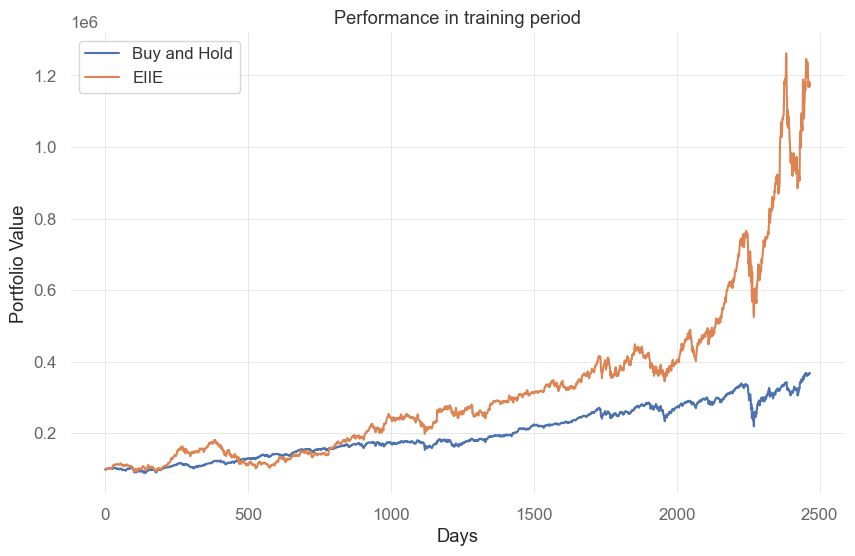

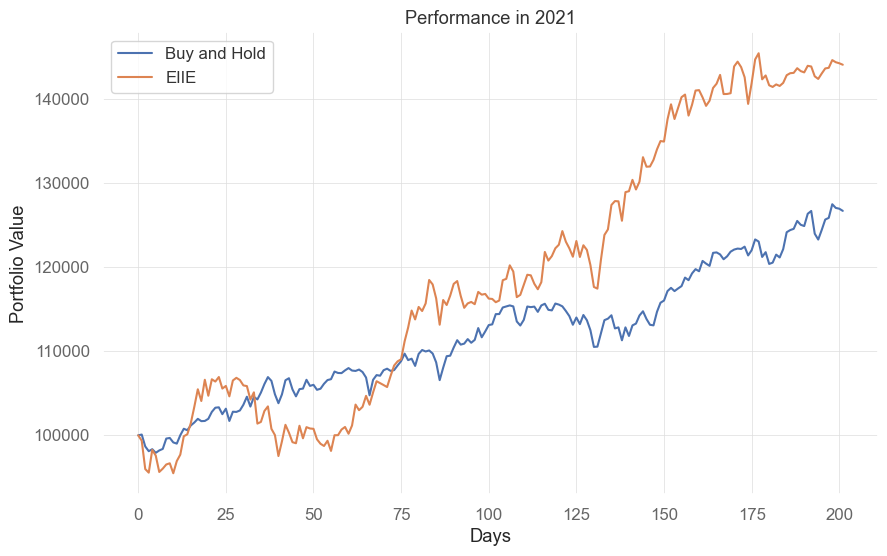

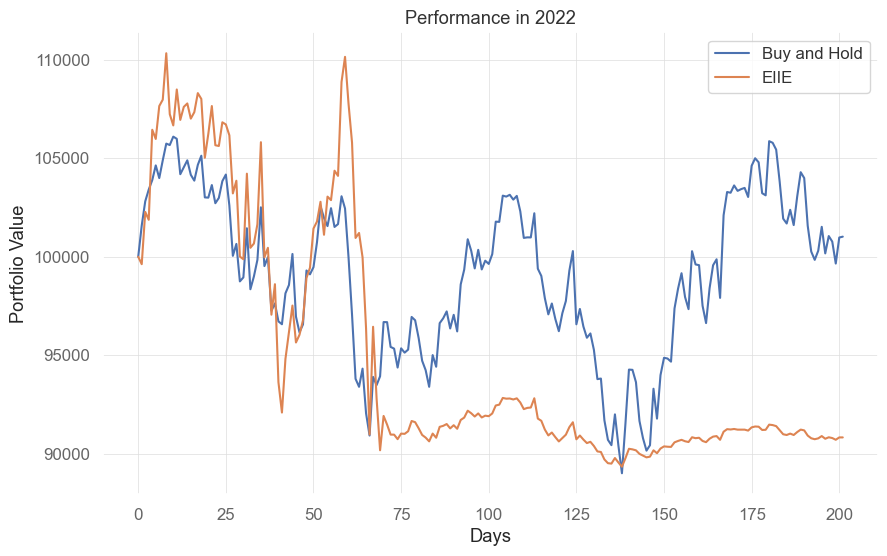

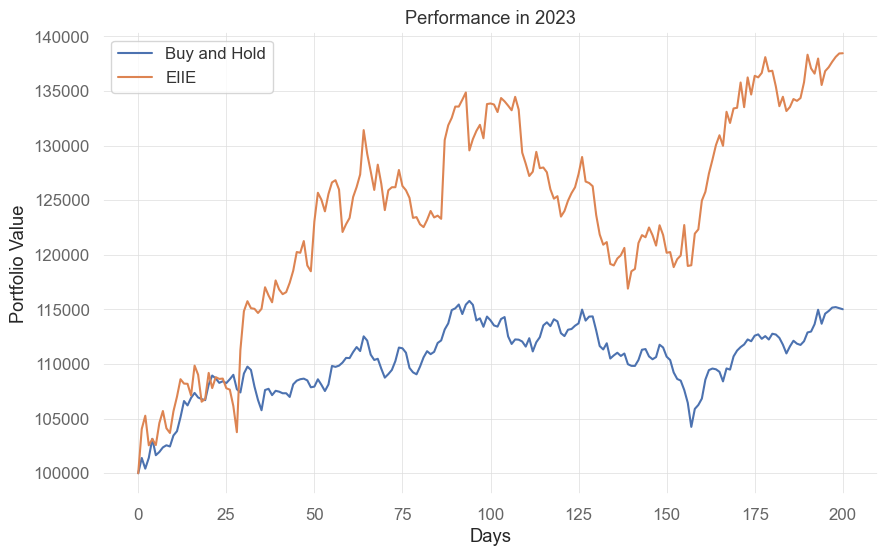

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
#plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")
#plt.plot(EI3_results["2021"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")
#plt.plot(EI3_results["2022"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")
#plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()

# Portfolio Allocation by Trained DRL Model

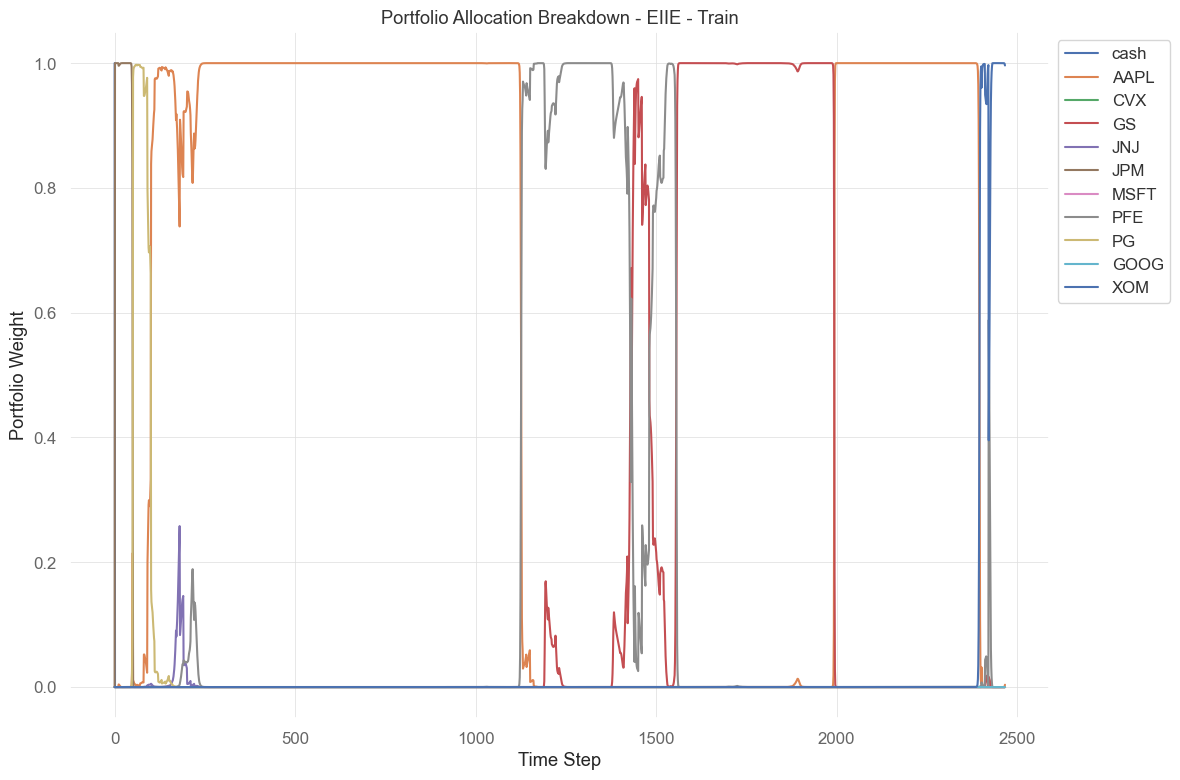

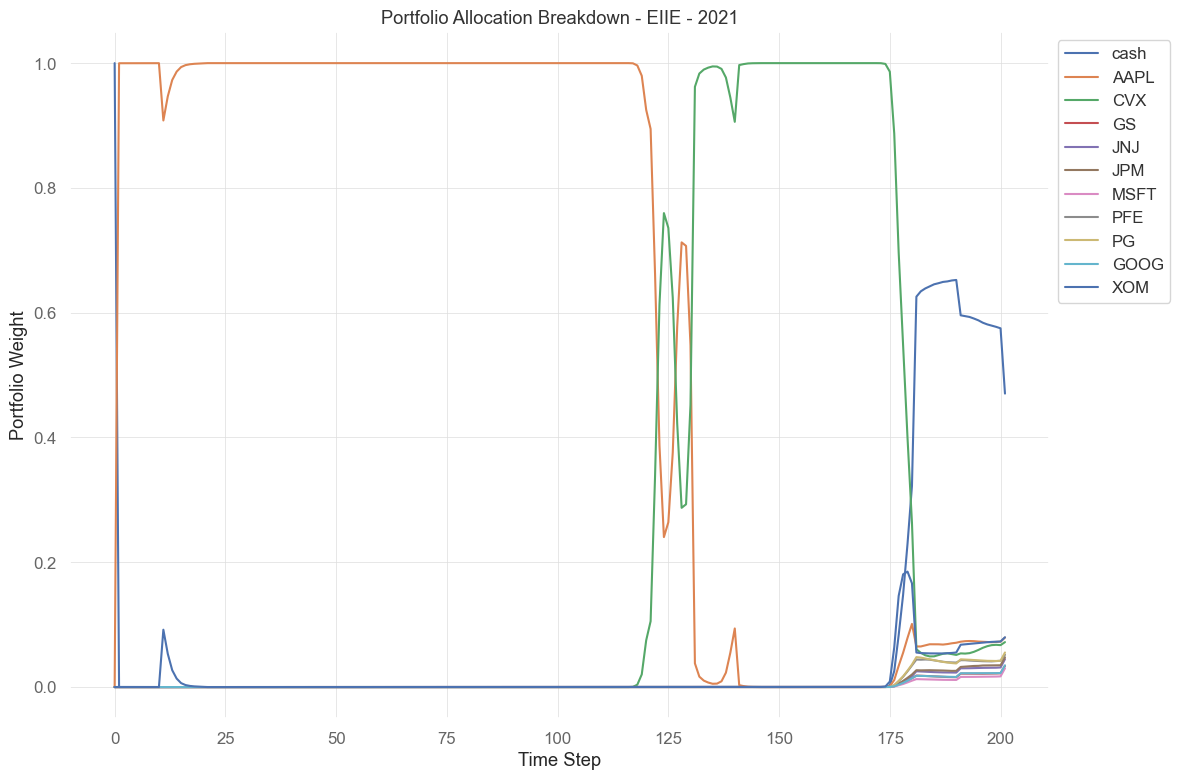

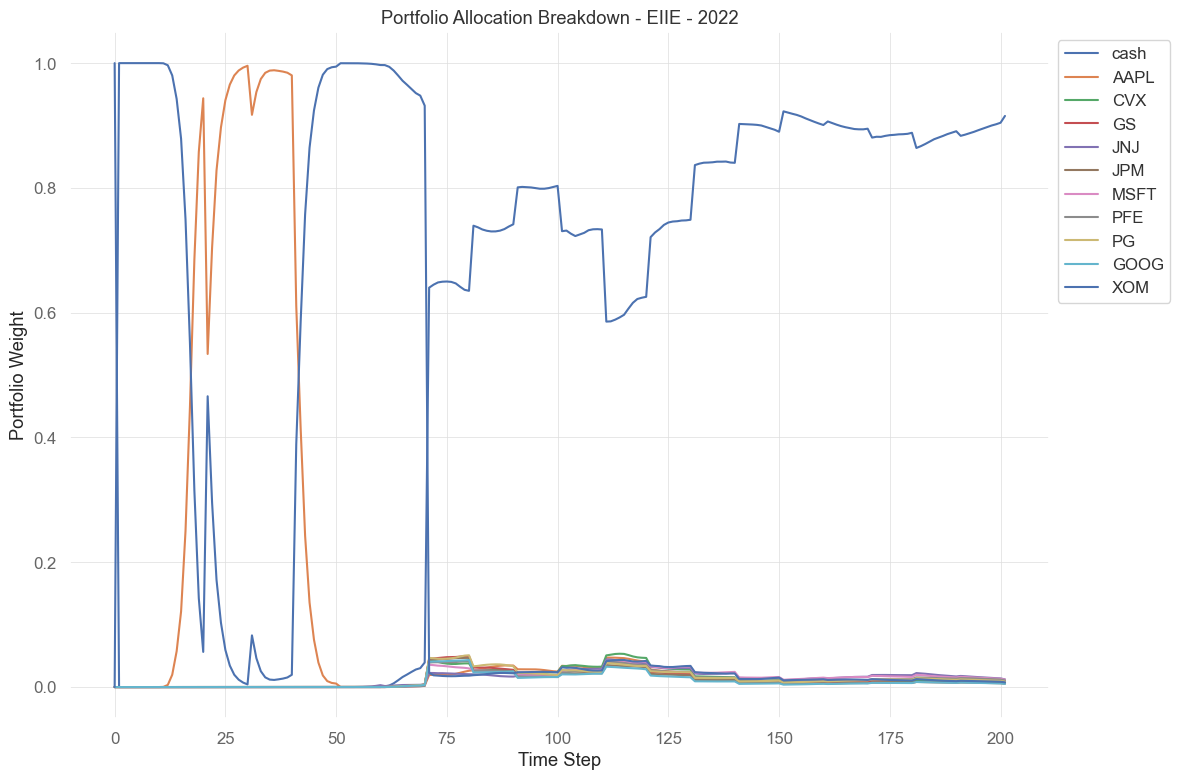

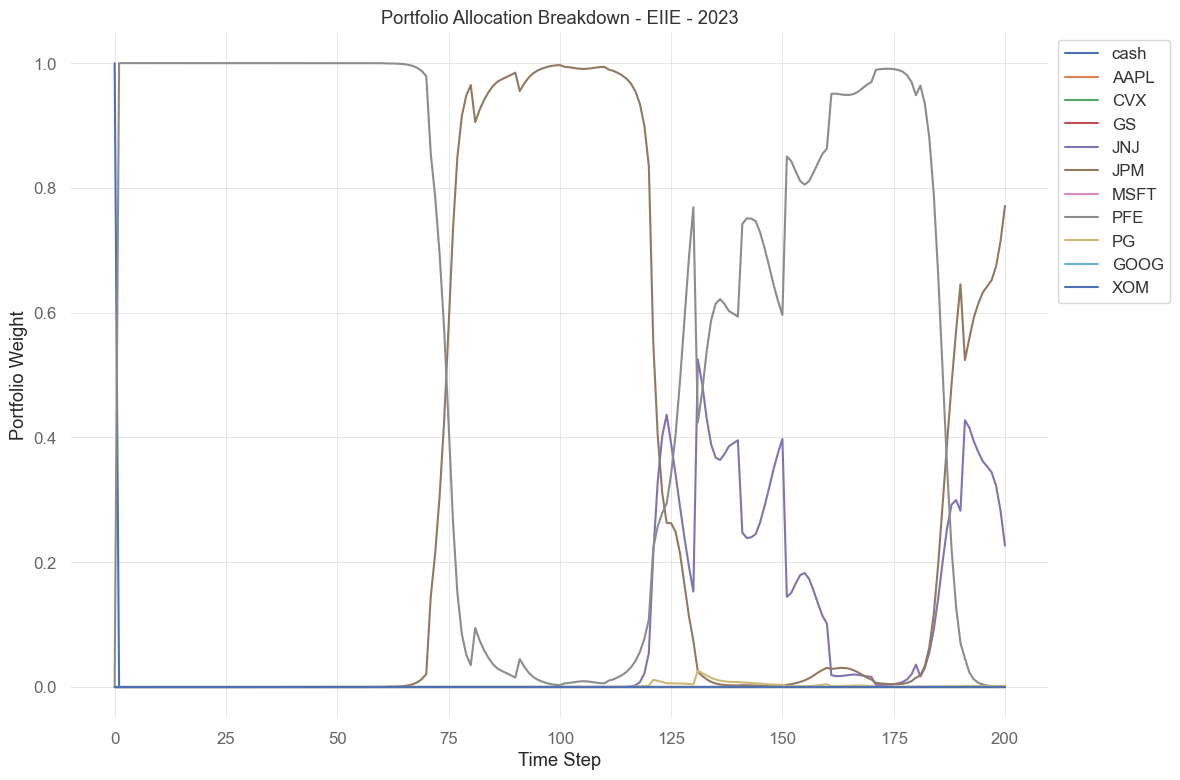

In [46]:
# Function to plot action memory
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="line", figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot EIIE actions for the training period
plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for 2021
plot_action_memory(EIIE_results["2021"]["actions"], TEST_SET, "EIIE - 2021")

# Plot EIIE actions for 2022
plot_action_memory(EIIE_results["2022"]["actions"], TEST_SET, "EIIE - 2022")

# Plot EIIE actions for 2023
plot_action_memory(EIIE_results["2023"]["actions"], TEST_SET, "EIIE - 2023")

# Similarly, plot UBAH actions for each period
# plot_action_memory(UBAH_results["train"]["actions"], TEST_SET, "UBAH - Train")
# plot_action_memory(UBAH_results["2021"]["actions"], TEST_SET, "UBAH - 2021")
# plot_action_memory(UBAH_results["2022"]["actions"], TEST_SET, "UBAH - 2022")
# plot_action_memory(UBAH_results["2023"]["actions"], TEST_SET, "UBAH - 2023")

In [47]:
temp_df = pd.DataFrame([{
        "TIME_WINDOW": TIME_WINDOW, "K_SIZE": K_SIZE, "CONV_MID": CONV_MID, "CONV_FINAL": CONV_FINAL,
        "train_portfolio_value": train_final_value, "train_drawdown": train_drawdown, "train_sharpe": train_sharpe, "train_cumulative": train_cumulative,
        "2021_portfolio_value": portfolio_2021_value, "2021_drawdown": drawdown_2021, "2021_sharpe": sharpe_2021, "2021_cumulative": cumulative_2021,
        "2022_portfolio_value": portfolio_2022_value, "2022_drawdown": drawdown_2022, "2022_sharpe": sharpe_2022, "2022_cumulative": cumulative_2022,
        "2023_portfolio_value": portfolio_2023_value, "2023_drawdown": drawdown_2023, "2023_sharpe": sharpe_2023, "2023_cumulative": cumulative_2023
    }])
    
results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
results_df

C:\Users\limyi\AppData\Local\Temp\ipykernel_31772\3317322918.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


,TIME_WINDOW,K_SIZE,CONV_MID,CONV_FINAL,train_portfolio_value,2021_portfolio_value,2022_portfolio_value,2023_portfolio_value,train_drawdown,2021_drawdown,2022_drawdown,2023_drawdown,train_sharpe,2021_sharpe,2022_sharpe,2023_sharpe,train_cumulative,2021_cumulative,2022_cumulative,2023_cumulative
0,50,4,5,20,1177754.75,144106.78125,90828.671875,138461.484375,-0.43796,-0.087967,-0.190261,-0.13316,1.029854,2.432154,-0.414494,1.932403,11.777548,1.441068,0.908287,1.384615


In [48]:
results_df.to_csv('filename.csv', index=False)

## Explainability
- We load the policy and want to describe feature importance
- SHAP
- LIME
- Saliency Maps


In [82]:
EIIE_policy = EIIE(time_window = TIME_WINDOW,
                   device = device, 
                   initial_features = len(FEATURE_NAMES),
                   k_size = K_SIZE, 
                   conv_mid_features = CONV_MID,
                   conv_final_features = CONV_FINAL)

EIIE_policy.load_state_dict(torch.load("policy_EIIE(test).pt"))
#for shap
# class EIIEWrapper(torch.nn.Module):
#     def __init__(self, policy, device):
#         super(EIIEWrapper, self).__init__()
#         self.policy = policy
#         self.device = device
    
#     def forward(self, input):
#         obs_tensor = input[0].float().to(self.device)
#         last_action_tensor = input[1].float().to(self.device)
#         return self.policy(obs_tensor, last_action_tensor)

# # Create the wrapper
# EIIE_wrapped = EIIEWrapper(EIIE_policy, device)

# Ensure the model is in evaluation mode
print(EIIE_policy.eval())
# Print out the weights of each layer in the policy
# for name, param in EIIE_policy.named_parameters():
#     if param.requires_grad:
#         print(f"Layer: {name}")
#         print(param.data)  # or param.grad to inspect gradients if necessary

# Create the environment with custom reward function
environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0,
    return_last_action=True
)

# Reset environment to get initial observation
environment_2021.reset()

# Initialize lists to store observations and last actions
obs_data_list = []
last_actions_list = []

# Collect observations and last actions over multiple steps
done = False
while not done:
    action = environment_2021.action_space.sample()  # Taking a random action
    next_obs, reward, done, info = environment_2021.step(action)
    
    # Convert observation to a tensor and store it
    if isinstance(next_obs, dict):
        obs_data_tensor = torch.tensor(next_obs["state"]).float().to(device)  # Extract "state" (observation)
        last_action_tensor = torch.tensor(next_obs["last_action"]).float().to(device)  # Extract "last_action"
    else:
        obs_data_tensor = torch.tensor(next_obs).float().to(device)
        last_action_tensor = torch.zeros((1, len(FEATURE_NAMES) + 1)).to(device)  # If no last_action provided
    
    # Append the tensors to the respective lists
    obs_data_list.append(obs_data_tensor)
    last_actions_list.append(last_action_tensor)

# Concatenate all collected observations and last actions into tensors
obs_data_tensors = torch.stack(obs_data_list)  # Shape: [num_steps, features, num_assets, time_window]
last_actions_tensors = torch.stack(last_actions_list)  # Shape: [num_steps, num_assets + 1]


/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_44241/1766192098.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("polic

EIIE(
  (sequential): Sequential(
    (0): Conv2d(11, 5, kernel_size=(1, 4), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 20, kernel_size=(1, 47), stride=(1, 1))
    (3): ReLU()
  )
  (final_convolution): Conv2d(21, 1, kernel_size=(1, 1), stride=(1, 1))
  (softmax): Sequential(
    (0): Softmax(dim=-1)
  )
)
Initial portfolio value:100000
Final portfolio value: 105681.46875
Final accumulative portfolio value: 1.0568146875
Maximum DrawDown: -0.06009114238903679
Sharpe ratio: 0.6821682712648369


In [45]:
#!pip install tensorflow
#!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.1/236.1 MB 4.2 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 4.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 3.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 972.6 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.0/398.0 kB 3.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 7.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.4 MB/s eta 0:00:00a 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.6 MB/s eta 0:00:00
  Using cached wheel-0.44.0-py3-none-any.whl (67 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 4.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installati

In [80]:
#shap not working
# import shap

# single_obs = obs_data_tensors[0]
# single_last_action = last_actions_tensors[0]
# single_obs = single_obs.unsqueeze(0)  # Shape: [1, 11, 10, 50]
# single_last_action = single_last_action.unsqueeze(0)  # Shape: [1, 11]

# # Combine the single observation and last action as input
# combined_input = (single_obs.to(device), single_last_action.to(device))

# # Create SHAP explainer for the policy network in PyTorch mode
# explainer = shap.DeepExplainer(EIIE_wrapped, combined_input)

# # Compute SHAP values for the single observation and single last action
# shap_values = explainer.shap_values(combined_input)

# # Visualize SHAP values for the observation
# shap.summary_plot(shap_values[0], single_obs.cpu().numpy())

# # Visualize SHAP values for the last action
# shap.summary_plot(shap_values[1], single_last_action.cpu().numpy())


AttributeError: 'numpy.ndarray' object has no attribute 'device'

In [91]:
import lime
from lime import lime_tabular
import torch
import numpy as np

# Assuming obs_data_tensors is a PyTorch tensor, convert it to NumPy array for LIME
obs_sample = obs_data_tensors[0].cpu().numpy()  # Convert first observation to NumPy

# Initialize LIME explainer for tabular data
explainer = lime_tabular.LimeTabularExplainer(
    training_data=obs_sample.reshape(1, -1),  # Flattened sample as background data
    mode='regression',  # Assuming your model predicts continuous values
    feature_names=[f'feature_{i}' for i in range(obs_sample.size)],  # Example feature names
    verbose=True,
    random_state=42
)

# Define a function that LIME will use to make predictions
def predict_fn(data):
    # Reshape data to match the expected input format for the model
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    batch_size = data_tensor.shape[0]
    
    # Adjust the dimensions to match your model's expected input format
    data_tensor = data_tensor.view(batch_size, 11, 10, 50)  # Example dimensions
    
    with torch.no_grad():
        # Assuming your policy model takes both observation and last action as inputs
        last_action = torch.zeros((batch_size, 11)).to(device)  # Mock last actions
        predictions = EIIE_policy(data_tensor, last_action)  # Forward pass
    return predictions 

# Generate explanation using LIME
exp = explainer.explain_instance(
    data_row=obs_sample.flatten(),  # Single observation
    predict_fn=predict_fn  # The function that makes predictions
)

# Visualize the explanation
exp.show_in_notebook(show_table=True)


Intercept 0.001153732438525185
Prediction_local [0.00115373]
Right: 0.00080349925


In [94]:
import lime
from lime import lime_tabular
import torch
import numpy as np

# Sample the first 10 observations and last actions for explanation
obs_samples = obs_data_tensors[:10].cpu().numpy()  # Convert first 10 observations to NumPy
last_action_samples = last_actions_tensors[:10].cpu().numpy()  # Convert corresponding last actions to NumPy

# Flatten the observation tensor for LIME, as LIME works with tabular data
obs_sample_flattened = obs_samples.reshape(len(obs_samples), -1)  # Flattened data

# Initialize LIME explainer for tabular data
explainer = lime_tabular.LimeTabularExplainer(
    training_data=obs_sample_flattened,  # Reshaped as background data for LIME
    mode='regression',  # Assuming your model predicts continuous values
    feature_names=[f'feature_{i}' for i in range(obs_sample_flattened.shape[1])],  # Example feature names
    verbose=True,
    random_state=42
)

# Define a function that LIME will use to make predictions
def predict_fn(data):
    # Reshape the flattened data back to the expected input format for the model
    batch_size = data.shape[0]
    
    # Reshape data back to its original shape: (batch_size, features, assets, time_window)
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    data_tensor = data_tensor.view(batch_size, 11, 10, 50)  # Adjust the dimensions
    
    with torch.no_grad():
        # Use the corresponding last actions for the batch
        last_action_tensor = torch.tensor(last_action_samples[:batch_size], dtype=torch.float32).to(device)
        predictions = EIIE_policy(data_tensor, last_action_tensor)  # Forward pass
    return predictions.cpu().numpy()  # Convert back to NumPy for LIME

# Loop through the batch of observations and generate LIME explanations
for i in range(len(obs_samples)):
    # Flatten the observation to match LIME input format
    data_row = obs_sample_flattened[i]

    # Generate explanation using LIME for each observation
    exp = explainer.explain_instance(
        data_row=data_row,  # Single flattened observation
        predict_fn=predict_fn  # The function that makes predictions
    )

    # Visualize the explanation for the current observation
    print(f"Explanation for observation {i + 1}:")
    exp.show_in_notebook(show_table=True)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 10 but got size 5000 for tensor number 1 in the list.